Student's Name : ROUBACHE Islam


# Classification

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
import matplotlib.image as img
import scipy.stats as ss
import seaborn as sns
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler,OneHotEncoder,OrdinalEncoder
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.tree import export_text
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from joblib import dump, load
import os
from sklearn.model_selection import ShuffleSplit,cross_validate,LearningCurveDisplay,KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score,make_scorer,confusion_matrix,roc_curve,auc
import graphviz 

import io
from io import StringIO
import sys

## Dataset Description

In [2]:
breast_cancer = pd.read_csv("breast-cancer_csv.csv")
breast_cancer.head()

,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat,Class
0,40-49,premeno,15-19,0-2,yes,3,right,left_up,no,recurrence-events
1,50-59,ge40,15-19,0-2,no,1,right,central,no,no-recurrence-events
2,50-59,ge40,35-39,0-2,no,2,left,left_low,no,recurrence-events
3,40-49,premeno,35-39,0-2,yes,3,right,left_low,yes,no-recurrence-events
4,40-49,premeno,30-34,3-5,yes,2,left,right_up,no,recurrence-events


In [3]:
breast_cancer.columns

Index(['age', 'menopause', 'tumor-size', 'inv-nodes', 'node-caps', 'deg-malig',
       'breast', 'breast-quad', 'irradiat', 'Class'],
      dtype='object')

In [4]:
breast_cancer.describe()

,deg-malig
count,286.000000
mean,2.048951
std,0.738217
min,1.000000
25%,2.000000
50%,2.000000
75%,3.000000
max,3.000000


In [5]:
breast_cancer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          286 non-null    object
 1   menopause    286 non-null    object
 2   tumor-size   286 non-null    object
 3   inv-nodes    286 non-null    object
 4   node-caps    278 non-null    object
 5   deg-malig    286 non-null    int64 
 6   breast       286 non-null    object
 7   breast-quad  285 non-null    object
 8   irradiat     286 non-null    object
 9   Class        286 non-null    object
dtypes: int64(1), object(9)
memory usage: 22.5+ KB


In [6]:
breast_cancer.isna().sum()

age            0
menopause      0
tumor-size     0
inv-nodes      0
node-caps      8
deg-malig      0
breast         0
breast-quad    1
irradiat       0
Class          0
dtype: int64

### Only one row contains Null value on the `breast-quad` column, we can drop it

In [7]:
breast_cancer.dropna(inplace=True)

In [8]:
breast_cancer.isna().sum()

age            0
menopause      0
tumor-size     0
inv-nodes      0
node-caps      0
deg-malig      0
breast         0
breast-quad    0
irradiat       0
Class          0
dtype: int64

<div class="alert alert-block alert-danger"> 
    
1. Plot the distribution of samples according to their classes. What do you observe? 
2. Code from scratch a mixed version of naive Bayes.
3. Verify if the dataset respects some related hypothesis to the following ML algorithms (such as Gaussian distribution and independency between features for naive Bayes, Linear Separability for Logistic regression..
....)  
4. Train the implemented mixed naive Bayes, SVM, KNN, Logistic regression, and Decision Tree (from
    sklearn) on all the breast cancer dataset.
5. Plot the graph of convergence of Logistic regression. 
6. Display, export, and import the generated models.
7. Evaluate the performance of the generated models using the 5-cross-validation evaluation method and
    display the confusion matrix for each split. Display the mean of recall, precision, f1-score, and the ROC curves.
8. Which evaluation metric do you recommend using for this dataset: unbalanced and medical?  
9. Import the best model according to the chosen metric and its pre-processings and predict the class of the third simple using the best model models.

   
   
<div/>

### 1- Plot the distribution of the samples according to their classes

<Axes: xlabel='Class'>

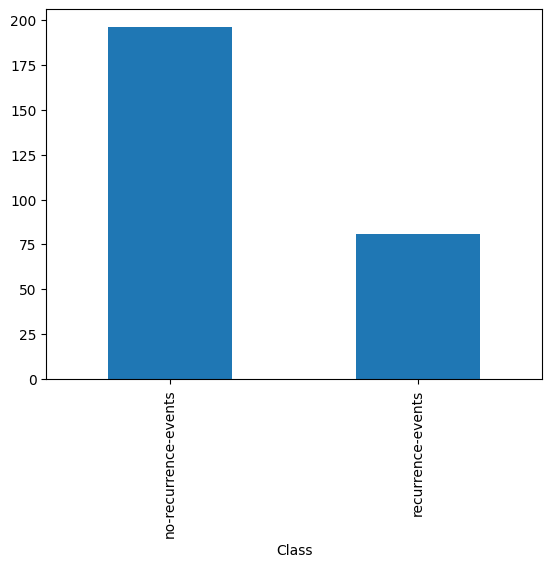

In [9]:
breast_cancer['Class'].value_counts().plot.bar()

we notice that the dataset is inbalanced,the recurrence events are minority.

### 2-The mixed naive bayes implementation

In [10]:
class MixteNaiveBayes:
    
    def __init__(self, categorical):
        self.model = None
        self.categorical = categorical
        self.classes = None
        self.columns = None

    def get_params(self, deep=True):
        return {
            'categorical': self.categorical,
        }

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
        
    def fit(self, X, Y):
        
        self.model = []
        self.classes, counts = np.unique(Y, return_counts = True)

        self.columns = X.columns if isinstance(X,pd.DataFrame) else np.arange(X.shape[1])
        
        for i in self.columns:

            if isinstance(X,pd.DataFrame):
                column = X[i]
            else:
                column =  X[:,i]
                        
            if i in self.categorical:
                p = self.__handle_categorical_attribute__(column, Y)
            else:
                p = self.__handle_numerical_attribute__(column, Y)
                
            self.model.append(p)
        
        probabilities = dict(zip(self.classes, counts / counts.sum()))
        self.model.append(probabilities)

        return self
        
            
    def predict(self, X):
        
        p = self.predict_proba(X)
        return self.classes[np.argmax(p, axis = 1)]
    
    def predict_proba(self, X):
        
        if self.model is None:
            raise Exception("fit was not called")
        
        y_hat = []
        n = X.shape[1]

        if isinstance(X,pd.DataFrame):
            X = X.iloc
                    
        for x in X:
            probailities = []
            for group in self.classes:
                p = 1
                for i in range(n):
                    if self.columns[i] in self.categorical:
                        key = x[i]
                        if key in self.model[i][group].keys():
                            p = p * self.model[i][group][x[i]]
                        # else:
                            # p = 0
                    else:
                        std = self.model[i][group]['std']
                        mean = self.model[i][group]['mean']
                        p = p * self.__gauss__(mean, std, x[i])
                p = p * self.model[-1][group]
                probailities.append(p)
            probailities = np.array(probailities)
            probailities = probailities / probailities.sum()
            y_hat.append(probailities)

        return np.array(y_hat)
        
    def __gauss__(self, mean, std, x):
        return np.exp(-0.5 * ((x - mean) / std) ** 2) / (np.sqrt(2 * np.pi) * std)
            
    def __handle_categorical_attribute__(self, column, Y):
        
        probabilities = {}
        values = np.unique(column)
        
        for group in self.classes:
            mask = Y == group
            _Y = Y[mask]
            _column = column[mask]
            probabilities[group] = {}
            for value in values:
                probabilities[group][value] = _Y[_column == value].shape[0] / _Y.shape[0]
                
        return probabilities
    
    def __handle_numerical_attribute__(self, column, Y):
        
        probabilities = {}
        
        for group in self.classes:
            
            _column = column[Y == group]
            
            mean = np.mean(_column)
            std = np.std(_column, ddof=1)
            
            probabilities[group] = {
                'mean': mean,
                'std': std
            }
            
        return probabilities

    def score(self, x, y, sample_weight=None):
        y_hat = self.predict(x)
        return np.mean(y_hat == y)

### 3- Verify the hypothesis 

#### Naive Bayes

1. Gaussian distribution

<Axes: ylabel='Frequency'>

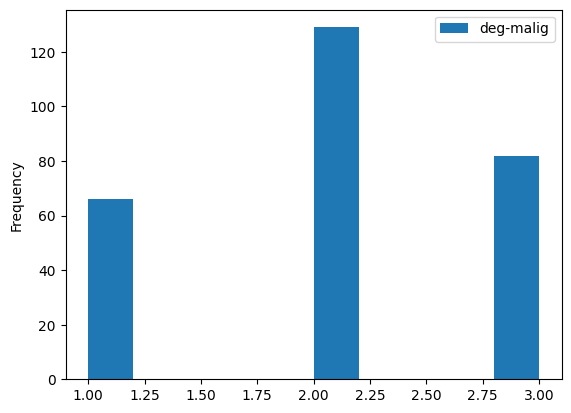

In [11]:
breast_cancer.select_dtypes(include = np.number).plot.hist()

2. features independance

to test the correlation between the attriutes of this dataset we will use the chi square test since all the features are categorical, details are available at : [Correlation between Categorical Variables](https://medium.com/@ritesh.110587/correlation-between-categorical-variables-63f6bd9bf2f7#:~:text=Chi%2DSquare%20test%20of%20independence,categorical%20variables%20is%20easily%20available.)

In [12]:
def chi_square_test(dataset):

    n = dataset.columns.shape[0]
    results = [[0] * n for _ in range(n)]

    for i,col1 in enumerate(dataset.columns):
        for j,col2 in enumerate(dataset.columns):
            if i == j:
                results[i][j] = np.nan
            elif i > j:
                results[i][j] = results[j][i]
            else:
                crosstab = pd.crosstab(dataset[col1], dataset[col2])
                contingency = ss.chi2_contingency(crosstab)[1]
                results[i][j] = contingency
    return pd.DataFrame(data = results, index = dataset.columns, columns = dataset.columns)

In [13]:
chi_matrix = chi_square_test(breast_cancer)

<Axes: >

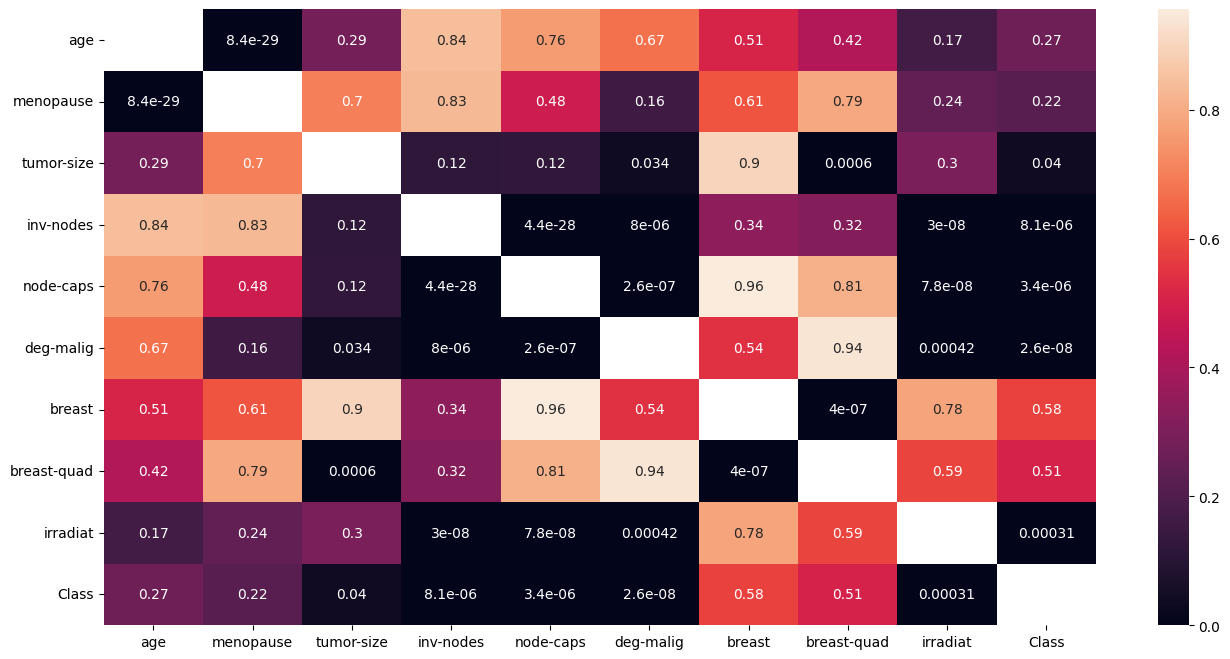

In [14]:
plt.rcParams["figure.figsize"] = (16, 8)
sns.heatmap(data = chi_matrix, annot = True)

the features with higher dependency 

In [15]:
rows, columns = np.where(chi_matrix < 0.05)
mask = rows > columns
rows = rows[mask]
columns = columns[mask]
list(zip(breast_cancer.columns[rows], breast_cancer.columns[columns]))

[('menopause', 'age'),
 ('node-caps', 'inv-nodes'),
 ('deg-malig', 'tumor-size'),
 ('deg-malig', 'inv-nodes'),
 ('deg-malig', 'node-caps'),
 ('breast-quad', 'tumor-size'),
 ('breast-quad', 'breast'),
 ('irradiat', 'inv-nodes'),
 ('irradiat', 'node-caps'),
 ('irradiat', 'deg-malig'),
 ('Class', 'tumor-size'),
 ('Class', 'inv-nodes'),
 ('Class', 'node-caps'),
 ('Class', 'deg-malig'),
 ('Class', 'irradiat')]

#### Logestic regression

1. Linear separibility

### 4- Training

#### split the data

In [16]:
X, Y = breast_cancer[breast_cancer.columns[breast_cancer.columns != "Class"]], breast_cancer["Class"].map({
    'no-recurrence-events': 0,
    'recurrence-events': 1
})

#### preprocessing

In [17]:
ordinal_cols = ['age', 'tumor-size', 'inv-nodes','node-caps','deg-malig', 'breast', 'irradiat']
one_hot_cols = ['menopause', 'breast-quad']

In [18]:
categories_order = []

for col in ordinal_cols:

    cats = breast_cancer[col].value_counts().index.tolist()

    if len(cats) != 2: # the column is in form of intervals => sort the categories
        cats.sort(key=lambda x: float(x.split("-")[0]) if isinstance(x, str) else x)
    
    categories_order.append(cats)

In [19]:
categories_order

[['20-29', '30-39', '40-49', '50-59', '60-69', '70-79'],
 ['0-4',
  '5-9',
  '10-14',
  '15-19',
  '20-24',
  '25-29',
  '30-34',
  '35-39',
  '40-44',
  '45-49',
  '50-54'],
 ['0-2', '3-5', '6-8', '9-11', '12-14', '15-17', '24-26'],
 ['no', 'yes'],
 [1, 2, 3],
 ['left', 'right'],
 ['no', 'yes']]

In [20]:
ordinal_transformer = Pipeline(steps=[
    ('ordinal_encoder', OrdinalEncoder(categories=categories_order))
])

In [21]:
one_hot_transformer = Pipeline(steps=[
    ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'))
])

In [22]:
preprocessor = ColumnTransformer(
    transformers=[
        ('ordinal', ordinal_transformer, ordinal_cols),
        ('one_hot', one_hot_transformer, one_hot_cols)
    ]
)

In [23]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler())
])

#### Logestic regression

In [24]:
def train(model, x, y):
    old_stdout = sys.stdout
    sys.stdout = mystdout = StringIO()
    model.fit(x,y)
    sys.stdout = old_stdout
    loss_history = mystdout.getvalue()
    loss_list = []
    for line in loss_history.split('\n'):
        if(len(line.split("loss: ")) == 1):
            continue
        loss_list.append(float(line.split("loss: ")[-1]))
    return np.array(loss_list)

- work with SGDCassifier class because it is based on gradient descent.

In [25]:
logistic_pipeline = Pipeline(steps=[
    ('preprocessing', pipeline),
    ('estimator', SGDClassifier(verbose = 1))
])

In [26]:
history = train(logistic_pipeline, X, Y)

In [27]:
logistic_pipeline.fit(X, Y)

-- Epoch 1
Norm: 88.63, NNZs: 15, Bias: -37.997408, T: 277, Avg. loss: 27.585844
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 61.39, NNZs: 15, Bias: -25.593264, T: 554, Avg. loss: 20.454529
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 67.10, NNZs: 15, Bias: -20.564510, T: 831, Avg. loss: 16.232951
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 51.41, NNZs: 15, Bias: -37.094343, T: 1108, Avg. loss: 15.781345
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 40.63, NNZs: 15, Bias: -36.397857, T: 1385, Avg. loss: 12.781310
Total training time: 0.00 seconds.
-- Epoch 6
Norm: 40.07, NNZs: 15, Bias: -20.163866, T: 1662, Avg. loss: 9.796479
Total training time: 0.00 seconds.
-- Epoch 7
Norm: 33.55, NNZs: 15, Bias: -27.082669, T: 1939, Avg. loss: 10.904326
Total training time: 0.00 seconds.
-- Epoch 8
Norm: 33.42, NNZs: 14, Bias: -20.349070, T: 2216, Avg. loss: 9.197778
Total training time: 0.00 seconds.
-- Epoch 9
Norm: 45.27, NNZs: 15, Bias: -8.857720, T: 2493, Avg. loss

,steps,"[('preprocessing', ...), ('estimator', ...)]"
,transform_input,None
,memory,None
,verbose,False
,steps,"[('preprocessor', ...), ('scaler', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('ordinal', ...), ('one_hot', ...)]"
,remainder,'drop'
,sparse_threshold,0.3


#### K-Nearset-Neighbors

In [28]:
knn_pipeline = Pipeline(steps=[
    ('preprocessing', pipeline),
    ('estimator', KNeighborsClassifier(n_neighbors = 7))
])

In [29]:
knn_pipeline.fit(X, Y)

,steps,"[('preprocessing', ...), ('estimator', ...)]"
,transform_input,None
,memory,None
,verbose,False
,steps,"[('preprocessor', ...), ('scaler', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('ordinal', ...), ('one_hot', ...)]"
,remainder,'drop'
,sparse_threshold,0.3


#### Mixte Naive Bayes

In [30]:
mnb_model = Pipeline(steps=[
    ('estimator',MixteNaiveBayes(categorical = breast_cancer.columns))
])

In [31]:
mnb_model.fit(X, Y)

,steps,"[('estimator', ...)]"
,transform_input,None
,memory,None
,verbose,False


#### Decision Tree

In [32]:
tree_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('estimator', DecisionTreeClassifier())
])

In [33]:
tree_pipeline.fit(X, Y)

,steps,"[('preprocessing', ...), ('estimator', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('ordinal', ...), ('one_hot', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


#### SVM

In [34]:
svm_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('estimator', SVC())
])
svm_pipeline.fit(X, Y)

,steps,"[('preprocessing', ...), ('estimator', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('ordinal', ...), ('one_hot', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### 5- Convergence graph for logestic regression

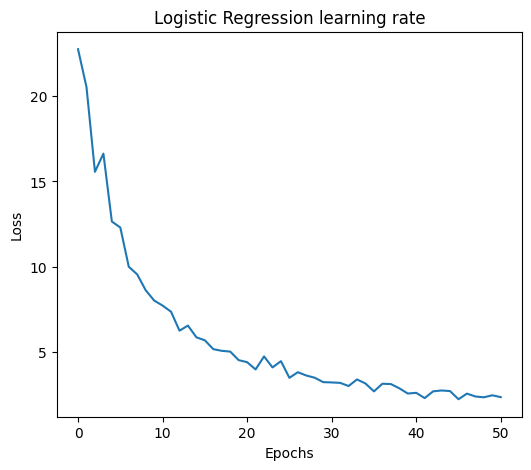

In [35]:
plt.rcParams['figure.figsize'] = [6, 5]

plt.title("Logistic Regression learning rate")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(history)

### 6- Display and Export the models

#### Display the models

1. Logestic Regression

In [36]:
logistic_pipeline['estimator'].coef_

array([[-1.57692493,  3.82179914,  1.3878094 , -1.14164705,  3.60613068,
        -1.20791799, -1.40881815, -2.32049927, -6.38433555,  4.01743057,
         3.91006135, -0.09378294,  0.44736656, -1.78798118, -2.18513333]])

2. Mixte Naive Bayes

In [37]:
dfs = []
index = []

for i,x in enumerate(mnb_model["estimator"].model[:-1]): 
    df = pd.DataFrame(x)
    dfs.append(df)
    index += [breast_cancer.columns[i]] * df.index.shape[0]

df = pd.concat(dfs)
df = df.set_index([index, df.index])

df

0         1
age         20-29      0.005102  0.000000
            30-39      0.107143  0.185185
            40-49      0.316327  0.333333
            50-59      0.352041  0.271605
            60-69      0.193878  0.209877
            70-79      0.025510  0.000000
menopause   ge40       0.459184  0.407407
            lt40       0.025510  0.000000
            premeno    0.515306  0.592593
tumor-size  0-4        0.035714  0.012346
            10-14      0.137755  0.012346
            15-19      0.117347  0.074074
            20-24      0.173469  0.172840
            25-29      0.168367  0.222222
            30-34      0.168367  0.296296
            35-39      0.061224  0.086420
            40-44      0.081633  0.074074
            45-49      0.010204  0.012346
            5-9        0.020408  0.000000
            50-54      0.025510  0.037037
inv-nodes   0-2        0.846939  0.530864
            12-14      0.005102  0.024691
            15-17      0.015306  0.037037
            24-26      0.000000  0.012346
            3-5        0.086735  0.209877
            6-8        0.035714  0.123457
            9-11       0.010204  0.061728
node-caps   no         0.872449  0.617284
            yes        0.127551  0.382716
deg-malig   1          0.290816  0.111111
            2          0.515306  0.345679
            3          0.193878  0.543210
breast      left       0.510204  0.555556
            right      0.489796  0.444444
breast-quad central    0.086735  0.049383
            left_low   0.372449  0.407407
            left_up    0.352041  0.308642
            right_low  0.086735  0.074074
            right_up   0.102041  0.160494
irradiat    no         0.836735  0.629630
            yes        0.163265  0.370370

In [38]:
mnb_model["estimator"].model[-1]

{0: 0.7075812274368231, 1: 0.2924187725631769}

3. Decision Tree

In [39]:
data = export_graphviz(tree_pipeline['estimator'])
graph = graphviz.Source(data, format="png") 
filename = graph.render("decision_tree_graphivz")

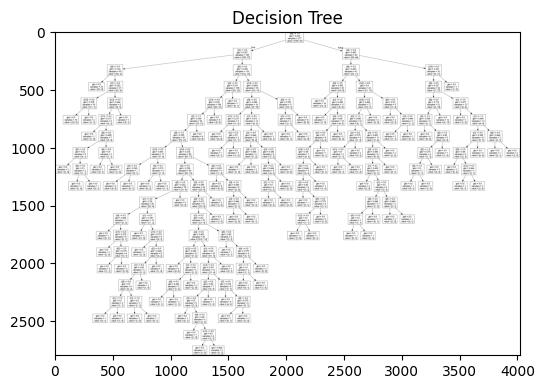

In [40]:
image = img.imread(filename)

plt.title("Decision Tree")
plt.imshow(image)
plt.show()

4. Support Vector Machine

In [41]:
svm_pipeline["estimator"].class_weight_

array([1., 1.])

#### Export the models

In [42]:
dump(value = logistic_pipeline, filename = os.path.join('models', 'lr.joblib'))
dump(value = knn_pipeline, filename = os.path.join('models', 'knn.joblib'))
dump(value = mnb_model, filename = os.path.join('models', 'mnb.joblib'))
dump(value = tree_pipeline, filename = os.path.join('models', 'dtree.joblib'))
dump(value = svm_pipeline, filename = os.path.join('models', 'svm.joblib'))

['models\\svm.joblib']

#### Import the models

In [43]:
lr = load(filename = os.path.join('models', 'lr.joblib'))
knn = load(filename = os.path.join('models', 'knn.joblib'))
mnb = load(filename = os.path.join('models', 'mnb.joblib'))
dtree = load(filename = os.path.join('models', 'dtree.joblib'))
svm = load(filename = os.path.join('models', 'svm.joblib'))

### 7- Performance evaluation

#### accuracy, precision, recall

In [44]:
def cm(score):
    def scorer(clf, X, y):
        y_pred = clf.predict(X)
        cm = confusion_matrix(y, y_pred)
        cm = {'tp': cm[0, 0], 'fp': cm[0, 1],
                'fn': cm[1, 0], 'tn': cm[1, 1]}

        return cm[score]
    return scorer

In [45]:
names = ['Logestic Regression', 'K-Nearset-Neighbors', 'Decision Tree', 'Support Vector Machine', 'Mixed Naive Bayes']
models = [lr, knn, dtree, svm, mnb]
series = []
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1_score': make_scorer(f1_score),
    'tn': cm('tn'),
    'tp': cm('tp'),
    'fp': cm('fp'),
    'fn': cm('fn')
}

In [46]:
confusion_matrices = []
k = 5

for i,model in enumerate(models):
    results = cross_validate(model, X, Y, cv=KFold(n_splits=k,shuffle=True), scoring=scoring)
    serie = []
    cms = [[],[]]
    for key in results.keys():
        if key not in ['fit_time', 'score_time','test_tn','test_tp','test_fp','test_fn']:
            serie.append(results[key].mean())

    for i in range(k):
        cms[0].extend([results["test_tp"][i],results["test_fp"][i]])
        cms[1].extend([results["test_fn"][i],results["test_tn"][i]])
                
    confusion_matrices.append(cms[0])  
    confusion_matrices.append(cms[1])  
    series.append(pd.Series(serie, index = ["accuracy", "precision", "recall", "f1-score"]))

-- Epoch 1
Norm: 93.07, NNZs: 15, Bias: -66.337367, T: 221, Avg. loss: 23.156378
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 82.11, NNZs: 15, Bias: -56.136499, T: 442, Avg. loss: 20.339582
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 59.30, NNZs: 15, Bias: -25.665153, T: 663, Avg. loss: 20.914049
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 58.96, NNZs: 15, Bias: -31.339847, T: 884, Avg. loss: 15.468817
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 60.72, NNZs: 15, Bias: -35.548041, T: 1105, Avg. loss: 13.159893
Total training time: 0.00 seconds.
-- Epoch 6
Norm: 43.67, NNZs: 15, Bias: -39.351574, T: 1326, Avg. loss: 12.841919
Total training time: 0.00 seconds.
-- Epoch 7
Norm: 39.66, NNZs: 15, Bias: -30.391617, T: 1547, Avg. loss: 11.777736
Total training time: 0.00 seconds.
-- Epoch 8
Norm: 41.99, NNZs: 15, Bias: -25.982569, T: 1768, Avg. loss: 9.530531
Total training time: 0.00 seconds.
-- Epoch 9
Norm: 37.44, NNZs: 15, Bias: -25.513018, T: 1989, Avg. los

C:\Users\iroub\AppData\Local\Temp\ipykernel_10392\1880576189.py:68: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  key = x[i]
C:\Users\iroub\AppData\Local\Temp\ipykernel_10392\1880576189.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p = p * self.model[i][group][x[i]]
c:\Users\iroub\anaconda3\Lib\site-packages\sklearn\pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
C:\Users\iroub\AppData\Local\Temp\ipykernel_103

In [47]:
df = pd.DataFrame(data=series, index = names)
df

,accuracy,precision,recall,f1-score
Logestic Regression,0.675325,0.414332,0.447692,0.419172
K-Nearset-Neighbors,0.692987,0.487302,0.214979,0.289294
Decision Tree,0.664805,0.451575,0.486694,0.462490
Support Vector Machine,0.732792,0.653333,0.181268,0.275196
Mixed Naive Bayes,0.750909,0.590851,0.524386,0.544762


#### confusion matrices

In [48]:
index = np.array(list(product(names, ["P", "N"])))
columns = np.array(list(product([f"Fold {i}" for i in range(5)], ["P", "N"])))

In [49]:
pd.DataFrame(confusion_matrices, index=[index[:,0],index[:,1]], columns = [columns[:,0],columns[:,1]])

Fold 0     Fold 1     Fold 2     Fold 3     Fold 4  \
                              P   N      P   N      P   N      P   N      P   
Logestic Regression    P     24  13     32   7     34   6     30  13     29   
                       N      6  13     14   3     11   4      8   4      4   
K-Nearset-Neighbors    P     37   2     37   7     28   8     39   2     34   
                       N     13   4     10   2     15   4      9   5     17   
Decision Tree          P     21  16     30  11     36   4     34   8     23   
                       N     10   9      9   6      8   7      7   6      7   
Support Vector Machine P     41   1     38   1     37   2     38   1     34   
                       N     12   2     15   2     13   3     14   2     12   
Mixed Naive Bayes      P     34   3     34   6     29  11     39   4     29   
                       N     11   8      8   8      6   9      7   5      6   

                              
                           N  
Logestic Regression    P   8  
                       N  14  
K-Nearset-Neighbors    P   2  
                       N   2  
Decision Tree          P  13  
                       N  12  
Support Vector Machine P   3  
                       N   6  
Mixed Naive Bayes      P   7  
                       N  13

#### ROC curves and auc scores

In [50]:
def is_probabilistic_model(model):
    has_predict_proba = getattr(model, 'predict_proba', None)
    has_probability = getattr(model, 'probability', None)
    return has_predict_proba and (has_probability is None or model.probability)

C:\Users\iroub\AppData\Local\Temp\ipykernel_10392\1880576189.py:68: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  key = x[i]
C:\Users\iroub\AppData\Local\Temp\ipykernel_10392\1880576189.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p = p * self.model[i][group][x[i]]
c:\Users\iroub\anaconda3\Lib\site-packages\sklearn\pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


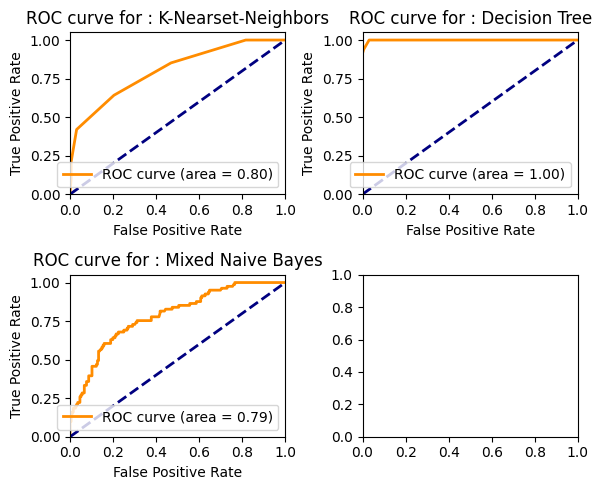

In [51]:
fig, axes = plt.subplots(nrows = 2,ncols = 2)

plt.rcParams["figure.figsize"] = (14,4)
i = 0

for j,model in enumerate(models):
    if is_probabilistic_model(model['estimator']):        
        y_hat = model.predict_proba(X)[:,1]
        fpr, tpr, thresholds = roc_curve(Y, y_hat)
        auc_score = auc(fpr, tpr)
        axe = axes[i // 2][i % 2]
    
        axe.plot(
            fpr,
            tpr,
            color="darkorange",
            lw=2,
            label="ROC curve (area = %0.2f)" % auc_score,
        )
        axe.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
        axe.set_xlim([0.0, 1.0])
        axe.set_ylim([0.0, 1.05])
        axe.set_xlabel("False Positive Rate")
        axe.set_ylabel("True Positive Rate")
        axe.set_title(f"ROC curve for : {names[j]}")
        axe.legend(loc="lower right")
        i += 1

plt.tight_layout()
plt.show()

### 8- Best metric

because the dataset is inablanced and medical so we would like to reduce the probability of predicting postive samples as negative, therfore the best metric to evaluate the models is : recall.

### 9- Choosing the best model

according to metric chosen in the previous question the best model is : Naive Bayes.

In [52]:
mixed_naive_bayes = load(filename = os.path.join('models', 'mnb.joblib'))

In [53]:
mixed_naive_bayes.score(X, Y)

C:\Users\iroub\AppData\Local\Temp\ipykernel_10392\1880576189.py:68: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  key = x[i]
C:\Users\iroub\AppData\Local\Temp\ipykernel_10392\1880576189.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p = p * self.model[i][group][x[i]]
c:\Users\iroub\anaconda3\Lib\site-packages\sklearn\pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


0.7689530685920578

In [54]:
n = 2
y = Y[n]
y_hat = mixed_naive_bayes.predict(X.iloc[[n]])

print(f"predicted class = {y_hat[0]}, actual class = {y}")

predicted class = 0, actual class = 1


C:\Users\iroub\AppData\Local\Temp\ipykernel_10392\1880576189.py:68: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  key = x[i]
C:\Users\iroub\AppData\Local\Temp\ipykernel_10392\1880576189.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p = p * self.model[i][group][x[i]]
